In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from collections import Counter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [3]:
pwd

'C:\\Users\\mnan\\Desktop\\viz\\house_pred_ML'

In [4]:
def false_na(train):
    train['GarageType']=train['GarageType'].replace({np.nan:'noGarage'})
    train['GarageFinish']=train['GarageFinish'].replace({np.nan:'noGarage'})
    train['GarageQual']=train['GarageQual'].replace({np.nan:'noGarage'})
    train['GarageCars']=train['GarageCars'].replace({np.nan:0})
    train['GarageArea']=train['GarageArea'].replace({np.nan:'0'})
    train['GarageCond']=train['GarageCond'].replace({np.nan:'noGarage'})
    
    train['BsmtExposure']=train['BsmtExposure'].replace({np.nan:'noBasement'})
    train['BsmtFinType2']=train['BsmtFinType2'].replace({np.nan:'noBasement'})
    train['BsmtFinType1']=train['BsmtFinType1'].replace({np.nan:'noBasement'})
    train['BsmtCond']=train['BsmtCond'].replace({np.nan:'noBasement'})
    train['BsmtQual']=train['BsmtQual'].replace({np.nan:'noBasement'})
    train['TotalBsmtSF']=train['TotalBsmtSF'].replace({np.nan:0})
    train['BsmtFinSF1']=train['BsmtFinSF1'].replace({np.nan:0})
    train['BsmtFinSF2']=train['BsmtFinSF2'].replace({np.nan:0})
    train['BsmtUnfSF']=train['BsmtUnfSF'].replace({np.nan:0})
    train['TotalBsmtSF']=train['TotalBsmtSF'].replace({np.nan:0})
    train['BsmtHalfBath']=train['BsmtHalfBath'].replace({np.nan:0})
    train['BsmtFullBath']=train['BsmtFullBath'].replace({np.nan:0})

    train['FireplaceQu']=train['FireplaceQu'].replace({np.nan:'noFireplace'})
    train['MasVnrType']=train['MasVnrType'].replace({np.nan:'noMasonryVeneer'})
    train['MasVnrArea']=train['MasVnrArea'].replace({np.nan:0})  
    train['MSZoning']=train['MSZoning'].replace({np.nan:'RL'})  
    train['Functional']=train['Functional'].replace({np.nan:'Typ'})  
    train['Exterior1st']=train['Exterior1st'].replace({np.nan:'VinylSd'})  
    train['Exterior2nd']=train['Exterior2nd'].replace({np.nan:'VinylSd'})  
    train['Electrical']=train['Electrical'].replace({np.nan:'SBrkr'})  
    train['SaleType']=train['SaleType'].replace({np.nan:'WD'}) 
    train['KitchenQual']=train['KitchenQual'].replace({np.nan:'TA'})  
    
    train['LotFrontage']=train['LotFrontage'].replace({np.nan:train['LotFrontage'].median()}) 
    
    return train

def check_dtype(df):
    for col in df.columns:
        df[col] = df[col].astype('float')
    print("Cols in df are all numerical is %s"%(sum([df[col].dtypes=='float'
                                                     for col in df.columns])==len(df.columns)))
    return df

def rmse_cv(estimator, X, y):
    rmse= np.sqrt(-cross_val_score(estimator, X, y, scoring="neg_mean_squared_error"))
    return(np.mean(rmse))

In [5]:
train = pd.read_csv("data/train.csv",index_col = 0)
test = pd.read_csv("data/test.csv",index_col = 0)

col_drop = list(pd.DataFrame(train.isnull().sum(),columns = ['missingVal'])
                .query('missingVal>0')
                .sort_values(by = 'missingVal',ascending = False)
                .index[:4])
## drop cols
for col in col_drop:
    train = train.drop(col, 1)
    test = test.drop(col,1)
    
train = train.drop('Utilities', 1) ## no data variety in Utilities
test = test.drop('Utilities', 1)
train = train.drop('GarageYrBlt',1) ## 'GarageYrBlt' duplicate with YearBuilt
test = test.drop('GarageYrBlt',1)
print('Now we have %d features'%test.shape[1])


test = false_na(test)
train = false_na(train)

df_dtypes = pd.DataFrame(train.dtypes,columns=['train_dtypes']).join(pd.DataFrame(test.dtypes,columns=['test_dtypes']))
df_dtypes_diff = df_dtypes.ix[df_dtypes['train_dtypes'] != df_dtypes['test_dtypes']]

for col in df_dtypes_diff.index[:6]:
    train[col] = train[col].astype('float')
train['GarageCars'] = train['GarageCars'].astype('float')
test['GarageArea'] = test['GarageArea'].astype('float')
train['GarageArea'] = train['GarageArea'].astype('float')

# check
df_dtypes0 = pd.DataFrame(train.dtypes,columns=['train_dtypes']).join(pd.DataFrame(test.dtypes,columns=['test_dtypes']))
print(df_dtypes0.ix[df_dtypes0['train_dtypes'] != df_dtypes0['test_dtypes']])



df_dtypes = pd.DataFrame(train.dtypes,columns = ['dtypes'])
numeric_cols = df_dtypes[df_dtypes['dtypes']!='object'].index
cate_cols = df_dtypes[df_dtypes['dtypes']=='object'].index

for col in cate_cols:
    le = preprocessing.LabelEncoder()
    le.fit(train[col].append(test[col]))
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])

    
train = check_dtype(train)
test = check_dtype(test)

selector = VarianceThreshold(0.8)
train_reduced = pd.DataFrame(selector.fit_transform(train),columns = train.columns[selector.get_support()])
test_reduced = pd.DataFrame(selector.fit_transform(test),columns = test.columns[selector.get_support()])


print('Now we only have %d features' % len(test_reduced.columns))
print("Features we remove are %s" % train.columns[~selector.get_support()])

Now we have 73 features
          train_dtypes test_dtypes
SalePrice        int64         NaN
Cols in df are all numerical is True
Cols in df are all numerical is True
Now we only have 45 features
Features we remove are Index(['MSZoning', 'Street', 'LandContour', 'LandSlope', 'Condition1',
       'Condition2', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtCond', 'Heating', 'CentralAir',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces', 'GarageCars',
       'GarageQual', 'GarageCond', 'PavedDrive'],
      dtype='object')


C:\Users\mnan\Anaconda3\lib\site-packages\pandas\indexes\base.py:1275: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 74 but corresponding boolean dimension is 73
  result = getitem(key)


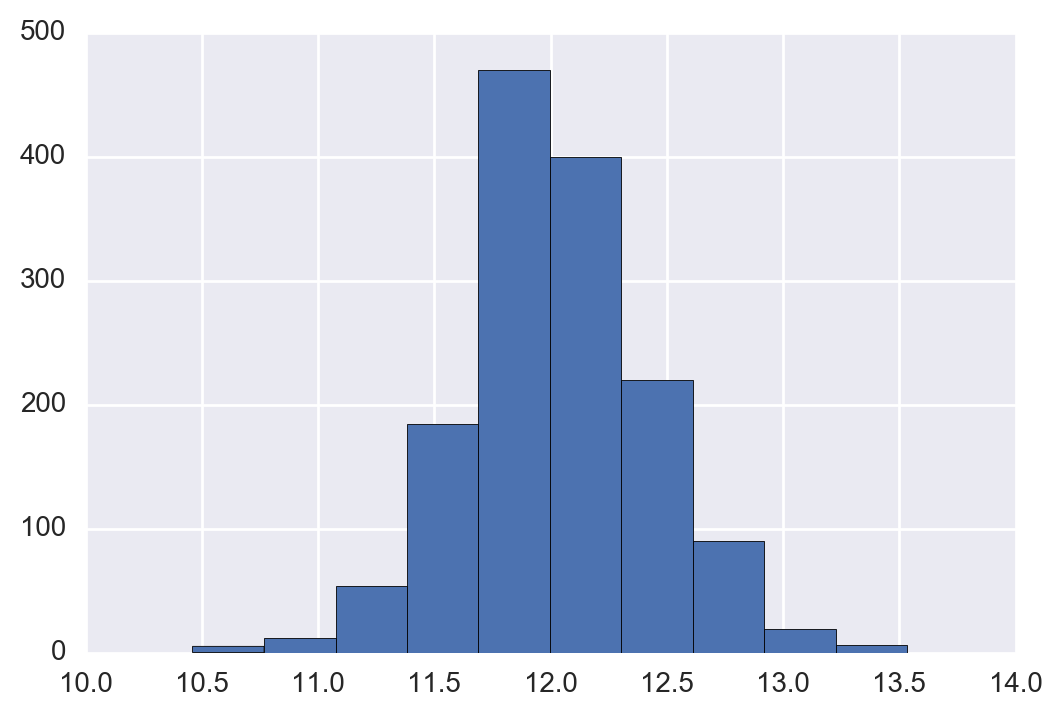

In [7]:
#log transform the target:
np.log1p(train_reduced["SalePrice"]).hist()

In [8]:
train_reduced["SalePrice"] = np.log1p(train_reduced["SalePrice"])

In [15]:
X = train_reduced.ix[:,:-1]
y = train_reduced.ix[:,-1]
forest = RandomForestRegressor()
scores= cross_val_score(forest,X,y,cv=10,scoring = rmse_cv) 

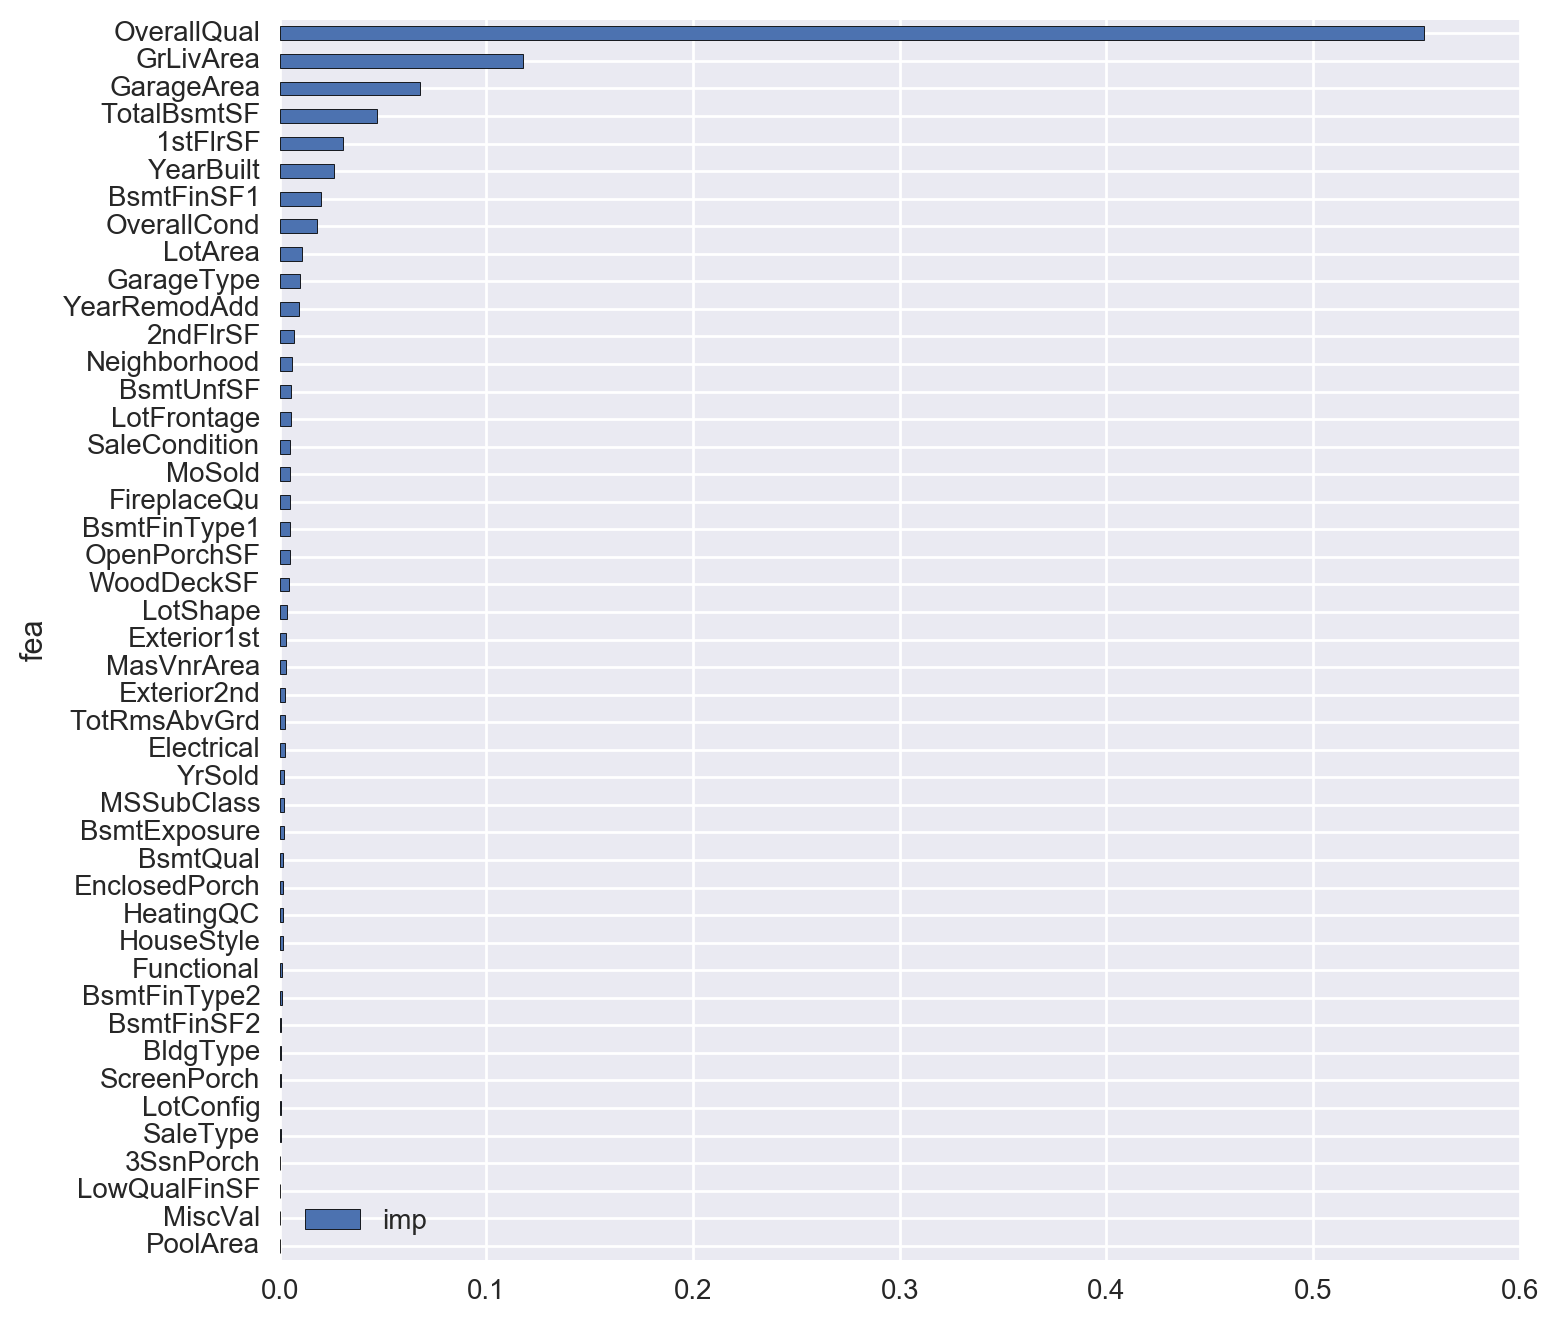

In [23]:
forest.fit(X,y)
feature_imp = forest.feature_importances_
pd.DataFrame.from_dict({'imp':feature_imp,'fea':train_reduced.columns[:-1]}).set_index('fea').sort_values('imp').plot(
    kind = 'barh',figsize = (8,8))